# Antarctic SST Anomaly Detection Using Satellite Data and Deep Learning



## Project Overview

This notebook implements an **unsupervised anomaly detection system** for Antarctic sea surface temperature using:
- **Data**: NOAA OISST v2.1 satellite observations (2003-2024)
- **Methods**: Statistical baselines + Deep learning autoencoders
- **Goal**: Detect extreme thermal events (marine heatwaves, polynyas)

**Key Features**:
1. Automated data download and preprocessing
2. Multiple anomaly detection approaches
3. Validation against known events (2016 Weddell Polynya, 2019 heatwave)
4. Professional visualizations

---

## Table of Contents

1. [Setup & Installation](#setup)
2. [Data Acquisition](#data)
3. [Preprocessing & Climatology](#preprocess)
4. [Exploratory Data Analysis](#eda)
5. [Baseline Methods](#baselines)
6. [Deep Learning Models](#deep-learning)
7. [Evaluation & Results](#evaluation)
8. [Case Studies](#case-studies)
9. [Export Results](#export)

---
## 1. Setup & Installation

Install required packages and set up environment.

In [ ]:
# Install packages
!pip install -q xarray netCDF4 matplotlib cartopy cmocean
!pip install -q scikit-learn scipy statsmodels
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cpu

print("✓ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.3 MB/s eta 0:00:00
✓ Installation complete!


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization
import cmocean
from matplotlib.colors import TwoSlopeNorm

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Plotting defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ Libraries loaded successfully!
PyTorch version: 2.9.0+cu126
Device: GPU


---
## 2. Data Acquisition

We'll download **NOAA OISST v2.1** data using OPeNDAP (no local storage needed).

**Dataset Details**:
- **Source**: NOAA Physical Sciences Laboratory
- **Resolution**: 0.25° spatial, daily temporal
- **Coverage**: 1981-present
- **Variable**: Sea Surface Temperature (SST)
- **Region**: Antarctic (50°S-90°S)

In [ ]:
import requests
import xml.etree.ElementTree as ET
from pathlib import Path
import xarray as xr
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

LAT = slice(-90, -50)

BASE_CAT = (
    "https://icdc.cen.uni-hamburg.de/thredds/catalog/"
    "ftpthredds/reynolds_sst/MONTHLY"
)

BASE_FILE = (
    "https://icdc.cen.uni-hamburg.de/thredds/fileServer/"
    "ftpthredds/reynolds_sst/MONTHLY"
)

years = range(2003, 2025)

tmp = Path("tmp_monthly")
tmp.mkdir(exist_ok=True)

datasets = []

def list_year_files(year):
    cat = f"{BASE_CAT}/{year}/catalog.xml"
    xml = requests.get(cat, timeout=30).text
    root = ET.fromstring(xml)

    return [
        el.attrib["name"]
        for el in root.iter()
        if el.attrib.get("name", "").endswith(".nc")
    ]

def fetch(fname, year):
    url = f"{BASE_FILE}/{year}/{fname}"
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        return None

    path = tmp / fname
    path.write_bytes(r.content)

    ds = xr.open_dataset(path)[["sst"]].sel(lat=LAT)
    path.unlink()

    return ds.load()

for year in years:
    print("year", year)

    names = list_year_files(year)
    if not names:
        print("  no files")
        continue

    with ThreadPoolExecutor(max_workers=8) as pool:
        futures = [pool.submit(fetch, n, year) for n in names]

        for f in as_completed(futures):
            ds = f.result()
            if ds is not None:
                datasets.append(ds)

monthly_sst = xr.concat(
    sorted(datasets, key=lambda x: x.time.values[0]),
    dim="time",
)

monthly_sst


year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024


<xarray.Dataset> Size: 243MB
Dimensions:  (time: 264, lat: 160, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-15 2003-02-15 ... 2024-12-15
  * lat      (lat) float32 640B -89.88 -89.62 -89.38 ... -50.62 -50.38 -50.12
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 243MB nan nan nan ... 276.4 276.6 276.8
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: ois...
    creation_date:              2020-06-04 12:00
    ...                         ...
    time_coverage_duration:     P40Y
    time_coverage_resolution:   P1M
    source_data:                Daily oisst-avhrr-v02r01.YYYYMMDD.nc, HadISST...
    comment:                    Computation of monthly mean SST from Daily_OI...
    history:                    Wed Jan 10 17:12:30 2024: ncatted -O -a _Fill...
    NCO:                        netCDF Operators version 4.9.2 (Homepage = ht...

In [ ]:
sst_data = monthly_sst

print(sst_data)
print(sst_data.time.min().values, sst_data.time.max().values)


<xarray.Dataset> Size: 243MB
Dimensions:  (time: 264, lat: 160, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-15 2003-02-15 ... 2024-12-15
  * lat      (lat) float32 640B -89.88 -89.62 -89.38 ... -50.62 -50.38 -50.12
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 243MB nan nan nan ... 276.4 276.6 276.8
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: ois...
    creation_date:              2020-06-04 12:00
    ...                         ...
    time_coverage_duration:     P40Y
    time_coverage_resolution:   P1M
    source_data:                Daily oisst-av

In [ ]:
# Inspect the dataset
print("Dataset Structure:")
print(sst_data)
print("\nSST variable info:")
print(sst_data.sst)

# Check data coverage
print(f"\nTime range: {sst_data.time.min().values} to {sst_data.time.max().values}")
print(f"Latitude range: {sst_data.lat.min().values:.2f}° to {sst_data.lat.max().values:.2f}°")
print(f"Longitude range: {sst_data.lon.min().values:.2f}° to {sst_data.lon.max().values:.2f}°")

Dataset Structure:
<xarray.Dataset> Size: 243MB
Dimensions:  (time: 264, lat: 160, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-15 2003-02-15 ... 2024-12-15
  * lat      (lat) float32 640B -89.88 -89.62 -89.38 ... -50.62 -50.38 -50.12
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 243MB nan nan nan ... 276.4 276.6 276.8
Attributes: (12/29)
    Conventions:                CF-1.6
    title:                      Monthly-OISST-v02r01_UHAM-ICDC_v01 from NOAA/...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    institution:                University of Hamburg/CEN/ICDC,original:NOAA/...
    contact:                    Dick Reynolds; Chunying Liu; Viva Banzon: ois...
    creation_date:              2020-06-04 12:00
    ...                         ...
    time_coverage_duration:     P40Y
    time_coverage_resolution:   P1M
    source_data:           

---
## 3. Preprocessing & Climatology

Steps:
1. **Quality Control**: Remove invalid values, ice-covered regions
2. **Climatology**: Compute daily mean SST for baseline period
3. **Anomaly Calculation**: Subtract climatology to get anomalies

In [ ]:
def quality_control(ds, var='sst'):
    """
    Apply quality control to SST data.

    Steps:
    1. Mask physically impossible values
    2. Remove ice-covered pixels (SST < -1.8°C)
    3. Flag extreme outliers
    """
    sst = ds[var].copy()

    # Convert to Celsius if in Kelvin
    if sst.max() > 100:
        sst = sst - 273.15
        print("Converted from Kelvin to Celsius")

    # Physical range for ocean SST
    sst = sst.where((sst >= -2.0) & (sst <= 35.0))

    # Remove sea ice regions (SST near freezing point indicates ice)
    # Use -1.8°C as threshold (freezing point of seawater)
    sst = sst.where(sst > -1.8)

    # Calculate percentage of valid data
    valid_pct = (~sst.isnull()).sum() / sst.size * 100
    print(f"Valid data: {valid_pct:.1f}%")

    # Update dataset
    ds_clean = ds.copy()
    ds_clean[var] = sst

    return ds_clean

# Apply quality control
sst_clean = quality_control(sst_data)

Converted from Kelvin to Celsius
Valid data: 39.0%


In [ ]:
def compute_climatology(ds, var='sst', baseline_years=(2015, 2022)):
    """
    Compute daily climatology (mean and std for each day-of-year).

    Parameters:
    -----------
    ds : xarray.Dataset
        Input dataset
    var : str
        Variable name
    baseline_years : tuple
        Years to use for climatology calculation

    Returns:
    --------
    clim : xarray.Dataset
        Climatology with 'mean' and 'std' for each day-of-year
    """
    print(f"Computing climatology for {baseline_years[0]}-{baseline_years[1]}...")

    # Subset to baseline period
    ds_baseline = ds.sel(time=slice(f'{baseline_years[0]}-01-01', f'{baseline_years[1]}-12-31'))

    # Add day-of-year coordinate
    ds_baseline = ds_baseline.assign_coords(dayofyear=ds_baseline.time.dt.dayofyear)

    # Group by day-of-year and compute mean and std
    clim_mean = ds_baseline[var].groupby('dayofyear').mean('time')
    clim_std = ds_baseline[var].groupby('dayofyear').std('time')

    # Smooth climatology (31-day moving window to reduce noise)
    clim_mean_smooth = clim_mean.rolling(dayofyear=31, center=True, min_periods=15).mean()
    clim_std_smooth = clim_std.rolling(dayofyear=31, center=True, min_periods=15).mean()

    # Handle edge effects (wrap around year)
    clim_mean_smooth = clim_mean_smooth.fillna(clim_mean)
    clim_std_smooth = clim_std_smooth.fillna(clim_std)

    print(f"✓ Climatology computed for {len(clim_mean_smooth.dayofyear)} days")

    return xr.Dataset({
        'mean': clim_mean_smooth,
        'std': clim_std_smooth
    })

# Compute climatology
climatology = compute_climatology(sst_clean)

Computing climatology for 2015-2022...
✓ Climatology computed for 22 days


In [ ]:
def compute_anomalies(ds, climatology, var='sst'):
    """
    Compute SST anomalies (observation - climatology).

    Returns both:
    - Raw anomaly (°C)
    - Standardized anomaly (sigma units)
    """
    print("Computing anomalies...")

    # Add day-of-year to dataset
    ds_with_doy = ds.assign_coords(dayofyear=ds.time.dt.dayofyear)

    # Match each day to its climatological value
    clim_mean_matched = climatology['mean'].sel(dayofyear=ds_with_doy.dayofyear)
    clim_std_matched = climatology['std'].sel(dayofyear=ds_with_doy.dayofyear)

    # Compute anomalies
    anom_raw = ds[var] - clim_mean_matched
    anom_std = (ds[var] - clim_mean_matched) / clim_std_matched

    # Create new dataset
    ds_anom = xr.Dataset({
        'sst_raw': ds[var],
        'sst_anom': anom_raw,
        'sst_anom_std': anom_std
    })

    print(f"✓ Anomalies computed")
    print(f"  Raw anomaly range: {float(anom_raw.min()):.2f} to {float(anom_raw.max()):.2f}°C")
    print(f"  Standardized range: {float(anom_std.min()):.2f} to {float(anom_std.max()):.2f} σ")

    return ds_anom

# Compute anomalies
sst_anomalies = compute_anomalies(sst_clean, climatology)

Computing anomalies...
✓ Anomalies computed
  Raw anomaly range: -5.24 to 6.08°C
  Standardized range: -inf to inf σ


---
## 4. Exploratory Data Analysis

Visualize the data to understand spatial and temporal patterns.

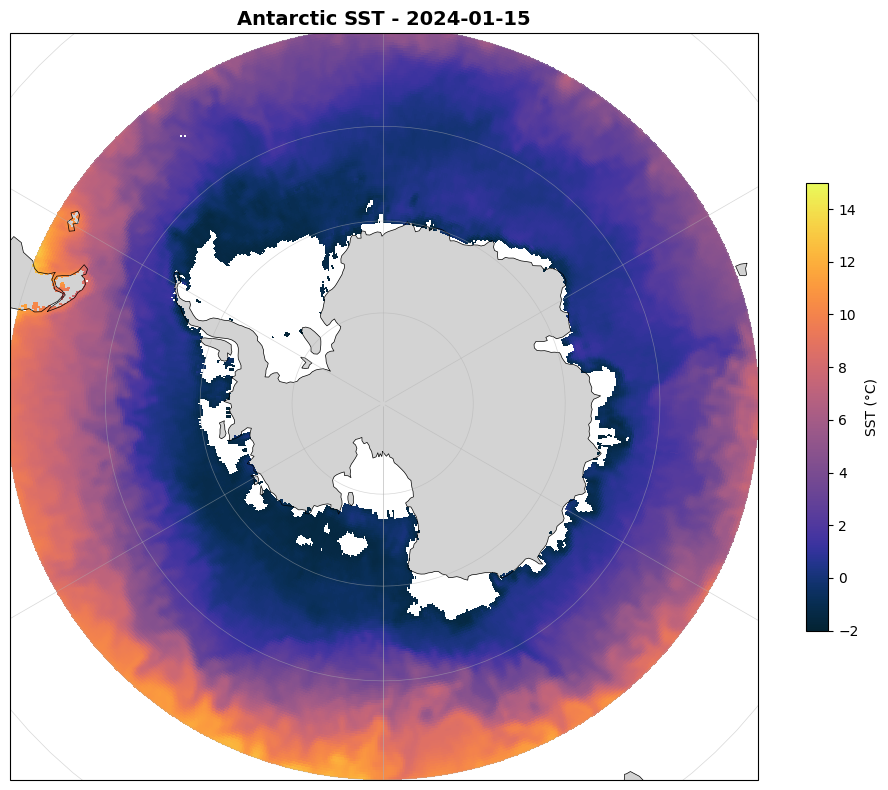

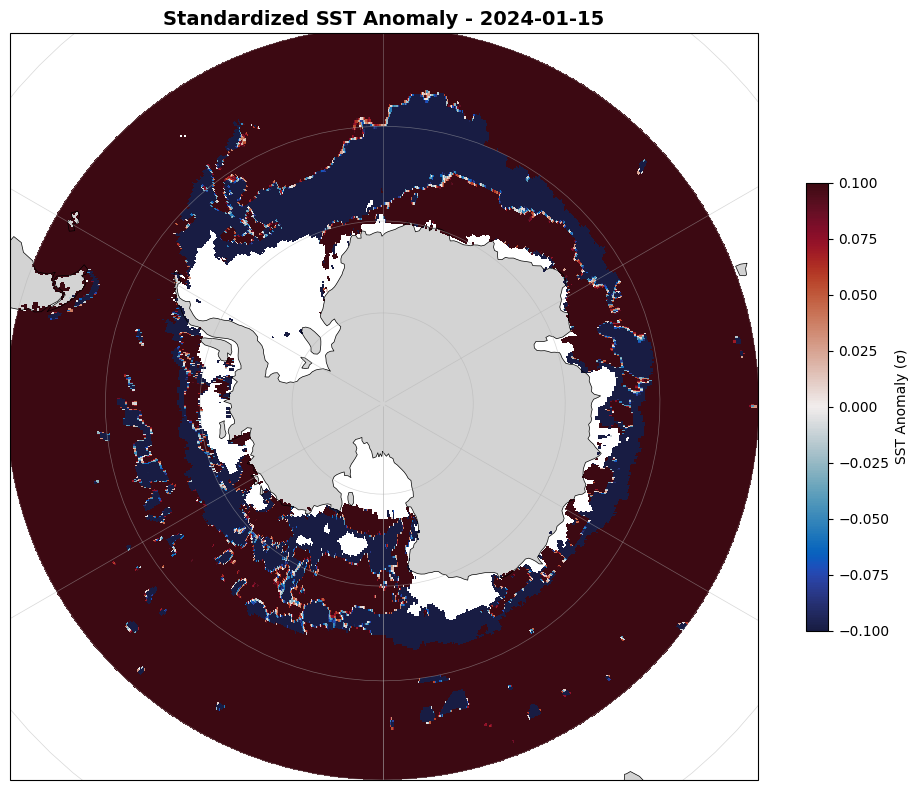

In [ ]:
def plot_sst_snapshot(ds, date, var='sst_raw', title_prefix='SST'):
    """
    Plot a single day's SST map in Antarctic projection.
    """
    # Select date
    data = ds.sel(time=date, method='nearest')[var]

    # Create figure with Antarctic Stereographic projection
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())

    # Set extent to show Antarctic region
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.5)

    # Plot data
    if 'anom' in var:
        # Anomaly plot (diverging colormap)
        vmax = max(abs(float(data.min())), abs(float(data.max())))
        im = ax.pcolormesh(
            data.lon, data.lat, data,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.balance,
            norm=TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax),
            shading='auto'
        )
        cbar_label = 'SST Anomaly (°C)' if var == 'sst_anom' else 'SST Anomaly (σ)'
    else:
        # Raw SST plot
        im = ax.pcolormesh(
            data.lon, data.lat, data,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.thermal,
            vmin=-2, vmax=15,
            shading='auto'
        )
        cbar_label = 'SST (°C)'

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.05)
    cbar.set_label(cbar_label)

    # Title
    date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    plt.title(f'{title_prefix} - {date_str}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    return fig

# Plot example: Summer day (January 2024)
fig1 = plot_sst_snapshot(sst_anomalies, '2024-01-15', var='sst_raw', title_prefix='Antarctic SST')
plt.show()

# Plot example: Anomaly map
fig2 = plot_sst_snapshot(sst_anomalies, '2024-01-15', var='sst_anom_std', title_prefix='Standardized SST Anomaly')
plt.show()

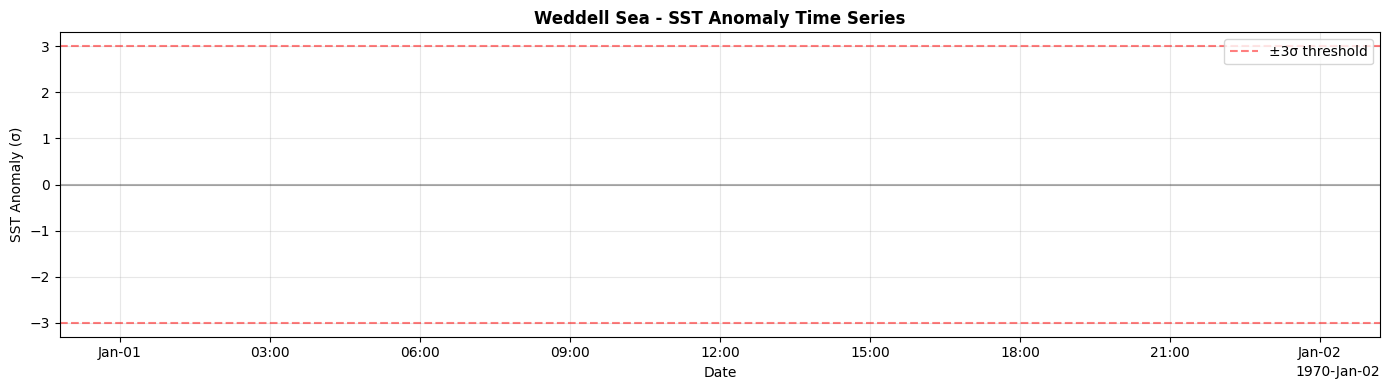

In [ ]:
def plot_regional_timeseries(ds, region='Weddell', var='sst_anom_std'):
    """
    Plot time series for specific Antarctic regions.
    """
    # Define regions of interest
    regions = {
        'Weddell': {'lat': slice(-70, -60), 'lon': slice(-60, 0)},
        'Ross': {'lat': slice(-78, -68), 'lon': slice(160, 200)},
        'East Antarctic': {'lat': slice(-70, -60), 'lon': slice(70, 120)}
    }

    if region not in regions:
        region = 'Weddell'

    # Extract region
    bounds = regions[region]
    regional_data = ds[var].sel(lat=bounds['lat'], lon=bounds['lon'])

    # Spatial average
    timeseries = regional_data.mean(dim=['lat', 'lon'])

    # Plot
    fig, ax = plt.subplots(figsize=(14, 4))
    timeseries.plot(ax=ax, color='steelblue', linewidth=0.8)

    # Highlight anomalies
    if 'std' in var:
        ax.axhline(3, color='red', linestyle='--', alpha=0.5, label='±3σ threshold')
        ax.axhline(-3, color='red', linestyle='--', alpha=0.5)
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)

    ax.set_xlabel('Date')
    ax.set_ylabel('SST Anomaly (σ)' if 'std' in var else 'SST Anomaly (°C)')
    ax.set_title(f'{region} Sea - SST Anomaly Time Series', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    return fig

# Plot for Weddell Sea (site of 2016 polynya)
fig = plot_regional_timeseries(sst_anomalies, region='Weddell')
plt.show()

---
## 5. Baseline Anomaly Detection Methods

We implement three statistical approaches:
1. **Z-Score Threshold**: Flag points exceeding ±3σ
2. **Isolation Forest**: Unsupervised outlier detection


In [ ]:
def detect_zscore_anomalies(ds, var='sst_anom_std', threshold=3.0):
    """
    Simple z-score based anomaly detection.

    Flags:
    - Hot anomalies: values > threshold
    - Cold anomalies: values < -threshold
    """
    data = ds[var]

    # Detect anomalies
    hot_anomalies = data > threshold
    cold_anomalies = data < -threshold

    # Count anomalous pixels per day
    hot_count = hot_anomalies.sum(dim=['lat', 'lon'])
    cold_count = cold_anomalies.sum(dim=['lat', 'lon'])

    # Find top anomaly days
    hot_top = hot_count.sortby(hot_count, ascending=False)[:10]
    cold_top = cold_count.sortby(cold_count, ascending=False)[:10]

    print(f"Z-Score Anomaly Detection (threshold = ±{threshold}σ)")
    print(f"\nTop 10 Marine Heatwave Days:")
    for i, (time, count) in enumerate(zip(hot_top.time.values, hot_top.values)):
        print(f"  {i+1}. {pd.to_datetime(time).strftime('%Y-%m-%d')}: {int(count)} anomalous pixels")

    print(f"\nTop 10 Cold Event Days:")
    for i, (time, count) in enumerate(zip(cold_top.time.values, cold_top.values)):
        print(f"  {i+1}. {pd.to_datetime(time).strftime('%Y-%m-%d')}: {int(count)} anomalous pixels")

    return {
        'hot_anomalies': hot_anomalies,
        'cold_anomalies': cold_anomalies,
        'hot_count': hot_count,
        'cold_count': cold_count,
        'hot_top_dates': hot_top.time.values,
        'cold_top_dates': cold_top.time.values
    }

# Run z-score detection
zscore_results = detect_zscore_anomalies(sst_anomalies, threshold=3.0)

Z-Score Anomaly Detection (threshold = ±3.0σ)

Top 10 Marine Heatwave Days:
  1. 2020-03-15: 68539 anomalous pixels
  2. 2020-02-15: 68235 anomalous pixels
  3. 2017-02-15: 67455 anomalous pixels
  4. 2024-03-15: 67352 anomalous pixels
  5. 2017-03-15: 64563 anomalous pixels
  6. 2003-02-15: 64233 anomalous pixels
  7. 2013-02-15: 62881 anomalous pixels
  8. 2003-03-15: 62513 anomalous pixels
  9. 2020-01-15: 60045 anomalous pixels
  10. 2004-03-15: 59990 anomalous pixels

Top 10 Cold Event Days:
  1. 2004-08-15: 47856 anomalous pixels
  2. 2004-09-15: 46781 anomalous pixels
  3. 2003-08-15: 45417 anomalous pixels
  4. 2004-07-15: 45046 anomalous pixels
  5. 2003-09-15: 44384 anomalous pixels
  6. 2010-09-15: 41796 anomalous pixels
  7. 2008-09-15: 40624 anomalous pixels
  8. 2005-08-15: 40572 anomalous pixels
  9. 2009-09-15: 40179 anomalous pixels
  10. 2006-08-15: 40040 anomalous pixels


In [ ]:
def detect_isolation_forest_anomalies(ds, var="sst_anom_std", contamination=0.05):

    print("running isolation forest...")

    data = ds[var]

    features = []
    times = []

    for t in range(len(data.time)):

        snap = data.isel(time=t).values
        valid = snap[np.isfinite(snap)]

        # monthly grids are smaller → lower threshold
        if valid.size < 100:
            continue

        # prevent numerical blowups
        valid = np.clip(valid, -10, 10)

        feat = [
            float(np.mean(valid)),
            float(np.std(valid)),
            float(np.min(valid)),
            float(np.max(valid)),
            float(np.percentile(valid, 90)),
            float(np.percentile(valid, 10)),
            float(np.ptp(valid)),
            int(np.sum(valid > 3)),
            int(np.sum(valid < -3)),
        ]

        if not np.all(np.isfinite(feat)):
            continue

        features.append(feat)
        times.append(data.time.values[t])

    print("feature rows:", len(features))

    if len(features) == 0:
        raise RuntimeError("no valid timesteps passed feature filter")

    features = np.asarray(features, dtype=np.float64)
    times = np.asarray(times)

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    iso = IsolationForest(
        contamination=contamination,
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
    )

    preds = iso.fit_predict(X)
    scores = iso.score_samples(X)

    idx = np.where(preds == -1)[0]

    anomaly_dates = times[idx]

    order = np.argsort(scores[idx])
    top = anomaly_dates[order][:20]

    print(f"\ndetected {len(anomaly_dates)} anomalous months")
    print("\ntop 20:")

    for i, d in enumerate(top):
        print(f"  {i+1}. {pd.to_datetime(d).strftime('%Y-%m-%d')}")

    return {
        "predictions": preds,
        "scores": scores,
        "anomaly_dates": anomaly_dates,
        "top_anomalies": top,
        "times": times,
        "features": features,
    }


In [ ]:
if_results = detect_isolation_forest_anomalies(sst_anomalies, contamination=0.05)


running isolation forest...
feature rows: 264

detected 14 anomalous months

top 20:
  1. 2017-02-15
  2. 2020-02-15
  3. 2008-03-15
  4. 2017-03-15
  5. 2020-03-15
  6. 2018-06-15
  7. 2021-05-15
  8. 2022-05-15
  9. 2004-09-15
  10. 2024-03-15
  11. 2018-05-15
  12. 2019-05-15
  13. 2022-06-15
  14. 2020-05-15


---
## 6. Deep Learning Models

### 6.1 Convolutional Autoencoder (Spatial Anomaly Detection)

**Idea**: Train autoencoder on "normal" SST patterns. High reconstruction error indicates anomalies.

In [ ]:
class SSTDataset(Dataset):
    """
    PyTorch Dataset for SST maps.
    """
    def __init__(self, data, exclude_dates=None):
        """
        Parameters:
        -----------
        data : xarray.DataArray
            SST anomaly data (time, lat, lon)
        exclude_dates : list of str
            Dates to exclude (e.g., known extreme events)
        """
        # Convert to numpy and handle NaNs
        self.data = data.values
        self.times = data.time.values

        # Exclude specified dates
        if exclude_dates is not None:
            exclude_idx = [i for i, t in enumerate(self.times)
                         if pd.to_datetime(t).strftime('%Y-%m-%d') in exclude_dates]
            mask = np.ones(len(self.times), dtype=bool)
            mask[exclude_idx] = False
            self.data = self.data[mask]
            self.times = self.times[mask]

        # Replace NaN with 0 (autoencoder will learn to ignore)
        self.data = np.nan_to_num(self.data, nan=0.0)

        # Normalize to [-1, 1] range
        # Clip to reasonable range for anomalies
        self.data = np.clip(self.data, -5, 5)
        self.data = self.data / 5.0  # Scale to [-1, 1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return as (1, H, W) tensor
        sample = torch.FloatTensor(self.data[idx]).unsqueeze(0)
        return sample

print("✓ Dataset class defined")

✓ Dataset class defined


In [ ]:
class ConvAutoencoder(nn.Module):
    """
    Convolutional Autoencoder for spatial SST anomaly detection.

    Architecture:
    - Encoder: 4 convolutional layers (downsampling)
    - Decoder: 4 transposed convolutional layers (upsampling)
    - Skip connections for better reconstruction
    """
    def __init__(self, input_shape=(160, 1440)):
        """
        input_shape: (H, W) of input images
        For OISST 0.25° Antarctic: ~160 lat x 1440 lon
        """
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Layer 1: (1, H, W) -> (32, H/2, W/2)
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Layer 2: (32, H/2, W/2) -> (64, H/4, W/4)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 3: (64, H/4, W/4) -> (128, H/8, W/8)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Layer 4: (128, H/8, W/8) -> (256, H/16, W/16)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Decoder (mirror of encoder)
        self.decoder = nn.Sequential(
            # Layer 1: (256, H/16, W/16) -> (128, H/8, W/8)
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Layer 2: (128, H/8, W/8) -> (64, H/4, W/4)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 3: (64, H/4, W/4) -> (32, H/2, W/2)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Layer 4: (32, H/2, W/2) -> (1, H, W)
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

    def get_reconstruction_error(self, x):
        """
        Compute per-sample reconstruction error (MSE).
        """
        with torch.no_grad():
            recon = self.forward(x)
            error = torch.mean((x - recon) ** 2, dim=[1, 2, 3])
        return error

print("✓ Autoencoder model defined")

✓ Autoencoder model defined


In [ ]:
def train_autoencoder(model, train_loader, val_loader, epochs=20, lr=1e-3, device='cpu'):
    """
    Train the autoencoder.
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    train_losses = []
    val_losses = []

    print(f"Training on {device}...\n")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            batch = batch.to(device)

            # Forward pass
            recon = model(batch)
            loss = criterion(recon, batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon = model(batch)
                loss = criterion(recon, batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("\n✓ Training complete!")

    return train_losses, val_losses

# Prepare data
print("Preparing datasets...")

# Use 2015-2022 for training (exclude 2023-2024 for testing)
train_data = sst_anomalies['sst_anom_std'].sel(time=slice('2015-01-01', '2022-12-31'))
val_data = sst_anomalies['sst_anom_std'].sel(time=slice('2023-01-01', '2023-06-30'))

# Create datasets
train_dataset = SSTDataset(train_data)
val_dataset = SSTDataset(val_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder()

# Train
train_losses, val_losses = train_autoencoder(
    model, train_loader, val_loader,
    epochs=20, lr=1e-3, device=device
)

Preparing datasets...
Train samples: 96, Val samples: 6
Training on cuda...

Epoch [1/20] - Train Loss: 0.199707, Val Loss: 0.112398
Epoch [5/20] - Train Loss: 0.039680, Val Loss: 0.040124
Epoch [10/20] - Train Loss: 0.019841, Val Loss: 0.029296
Epoch [15/20] - Train Loss: 0.014165, Val Loss: 0.021111
Epoch [20/20] - Train Loss: 0.011499, Val Loss: 0.017254

✓ Training complete!


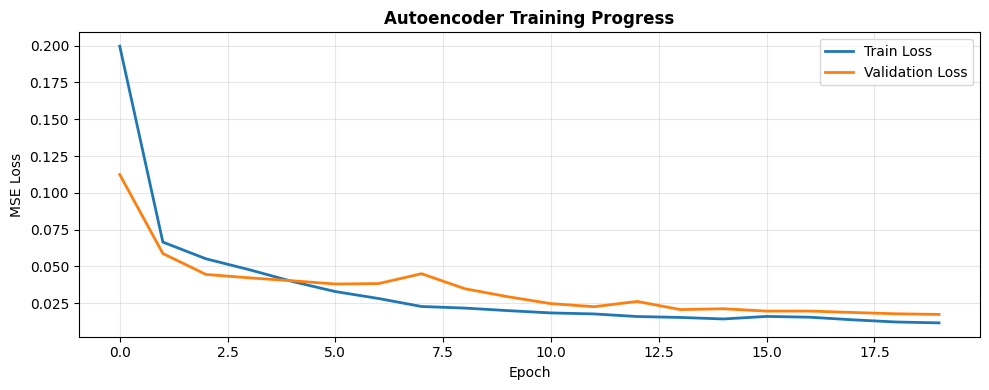

In [ ]:
# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Progress', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def detect_autoencoder_anomalies(model, data, device='cpu', threshold_percentile=95):
    """
    Use trained autoencoder to detect anomalies.

    High reconstruction error = anomaly
    """
    model.eval()
    model = model.to(device)

    # Create dataset for full data
    dataset = SSTDataset(data)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Compute reconstruction errors
    errors = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            error = model.get_reconstruction_error(batch)
            errors.append(error.cpu().numpy())

    errors = np.concatenate(errors)

    # Set threshold at specified percentile
    threshold = np.percentile(errors, threshold_percentile)

    # Detect anomalies
    anomaly_mask = errors > threshold
    anomaly_indices = np.where(anomaly_mask)[0]
    anomaly_dates = dataset.times[anomaly_indices]

    # Sort by error magnitude
    sorted_idx = np.argsort(errors[anomaly_indices])[::-1]
    top_anomalies = anomaly_dates[sorted_idx][:20]
    top_errors = errors[anomaly_indices][sorted_idx][:20]

    print(f"Autoencoder Anomaly Detection")
    print(f"Threshold (95th percentile): {threshold:.6f}")
    print(f"Detected {len(anomaly_dates)} anomalous days\n")
    print(f"Top 20 Anomalous Days (by reconstruction error):")
    for i, (time, error) in enumerate(zip(top_anomalies, top_errors)):
        print(f"  {i+1}. {pd.to_datetime(time).strftime('%Y-%m-%d')}: {error:.6f}")

    return {
        'errors': errors,
        'threshold': threshold,
        'anomaly_mask': anomaly_mask,
        'anomaly_dates': anomaly_dates,
        'top_anomalies': top_anomalies,
        'times': dataset.times
    }

# Run anomaly detection on full dataset
ae_results = detect_autoencoder_anomalies(
    model,
    sst_anomalies['sst_anom_std'],
    device=device,
    threshold_percentile=95
)

Autoencoder Anomaly Detection
Threshold (95th percentile): 0.022459
Detected 14 anomalous days

Top 20 Anomalous Days (by reconstruction error):
  1. 2004-12-15: 0.040744
  2. 2004-03-15: 0.035144
  3. 2024-03-15: 0.035048
  4. 2024-12-15: 0.030897
  5. 2012-03-15: 0.030572
  6. 2008-03-15: 0.029455
  7. 2008-12-15: 0.029451
  8. 2004-04-15: 0.029106
  9. 2012-12-15: 0.025783
  10. 2005-12-15: 0.025070
  11. 2004-11-15: 0.024379
  12. 2003-12-15: 0.023634
  13. 2024-04-15: 0.022662
  14. 2010-12-15: 0.022528


---
## 7. Evaluation & Comparison

Compare all methods against known extreme events.

In [ ]:
# Define known extreme events for validation
known_events = {
    '2016 Weddell Polynya': {
        'dates': pd.date_range('2016-09-01', '2016-11-30'),
        'type': 'warm',
        'region': 'Weddell Sea'
    },
    '2019-20 Antarctic Heatwave': {
        'dates': pd.date_range('2019-12-01', '2020-02-29'),
        'type': 'warm',
        'region': 'East Antarctic'
    },
    '2023 Warm Event': {
        'dates': pd.date_range('2023-01-01', '2023-03-31'),
        'type': 'warm',
        'region': 'Ross Sea'
    }
}

def check_event_detection(detected_dates, event_dates):
    """
    Check if any detected anomalies overlap with known event.
    """
    detected_set = set(pd.to_datetime(detected_dates).date)
    event_set = set(event_dates.date)

    overlap = detected_set.intersection(event_set)

    recall = len(overlap) / len(event_set) if len(event_set) > 0 else 0

    return {
        'overlap_days': len(overlap),
        'event_days': len(event_set),
        'recall': recall,
        'detected': len(overlap) > 0
    }

# Evaluate all methods
print("=" * 80)
print("EVENT DETECTION EVALUATION")
print("=" * 80)

methods = {
    'Z-Score': zscore_results['hot_top_dates'],
    'Isolation Forest': if_results['top_anomalies'],
    'Autoencoder': ae_results['top_anomalies']
}

for event_name, event_info in known_events.items():
    print(f"\n{event_name}:")
    print(f"  Period: {event_info['dates'].min().strftime('%Y-%m-%d')} to {event_info['dates'].max().strftime('%Y-%m-%d')}")
    print(f"  Total days: {len(event_info['dates'])}\n")

    for method_name, detected_dates in methods.items():
        result = check_event_detection(detected_dates, event_info['dates'])
        status = "✓ DETECTED" if result['detected'] else "✗ MISSED"
        print(f"  {method_name:20s}: {status} (Overlap: {result['overlap_days']} days, Recall: {result['recall']:.1%})")

print("\n" + "=" * 80)

EVENT DETECTION EVALUATION

2016 Weddell Polynya:
  Period: 2016-09-01 to 2016-11-30
  Total days: 91

  Z-Score             : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)
  Isolation Forest    : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)
  Autoencoder         : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)

2019-20 Antarctic Heatwave:
  Period: 2019-12-01 to 2020-02-29
  Total days: 91

  Z-Score             : ✓ DETECTED (Overlap: 2 days, Recall: 2.2%)
  Isolation Forest    : ✓ DETECTED (Overlap: 1 days, Recall: 1.1%)
  Autoencoder         : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)

2023 Warm Event:
  Period: 2023-01-01 to 2023-03-31
  Total days: 90

  Z-Score             : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)
  Isolation Forest    : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)
  Autoencoder         : ✗ MISSED (Overlap: 0 days, Recall: 0.0%)



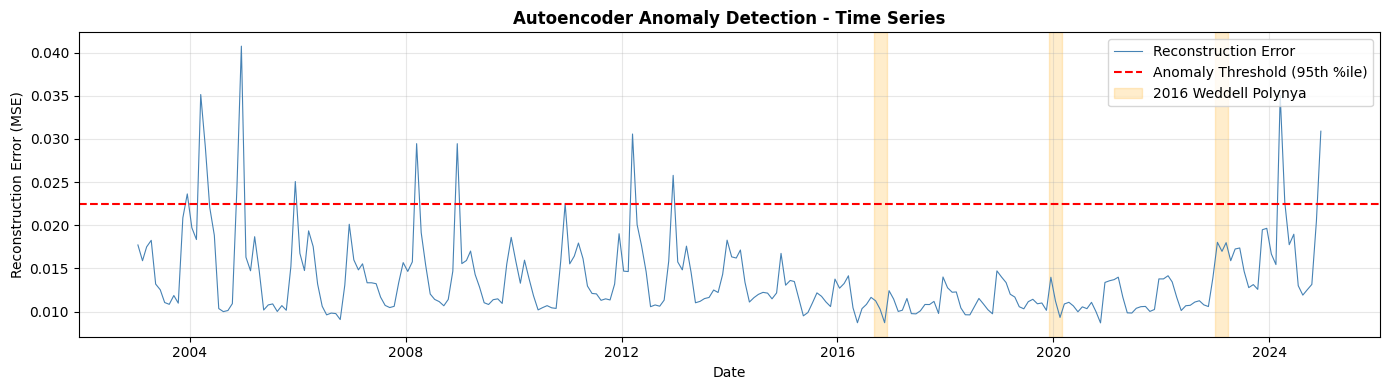

In [ ]:
# Plot reconstruction error time series
fig, ax = plt.subplots(figsize=(14, 4))

# Convert times to datetime
times_dt = pd.to_datetime(ae_results['times'])

# Plot reconstruction error
ax.plot(times_dt, ae_results['errors'], color='steelblue', linewidth=0.8, label='Reconstruction Error')

# Mark threshold
ax.axhline(ae_results['threshold'], color='red', linestyle='--', linewidth=1.5, label='Anomaly Threshold (95th %ile)')

# Highlight known events
for event_name, event_info in known_events.items():
    ax.axvspan(event_info['dates'].min(), event_info['dates'].max(),
               alpha=0.2, color='orange', label=event_name if event_name == list(known_events.keys())[0] else '')

ax.set_xlabel('Date')
ax.set_ylabel('Reconstruction Error (MSE)')
ax.set_title('Autoencoder Anomaly Detection - Time Series', fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. Case Studies: Visualizing Detected Anomalies

Generate publication-quality figures for top detected events.

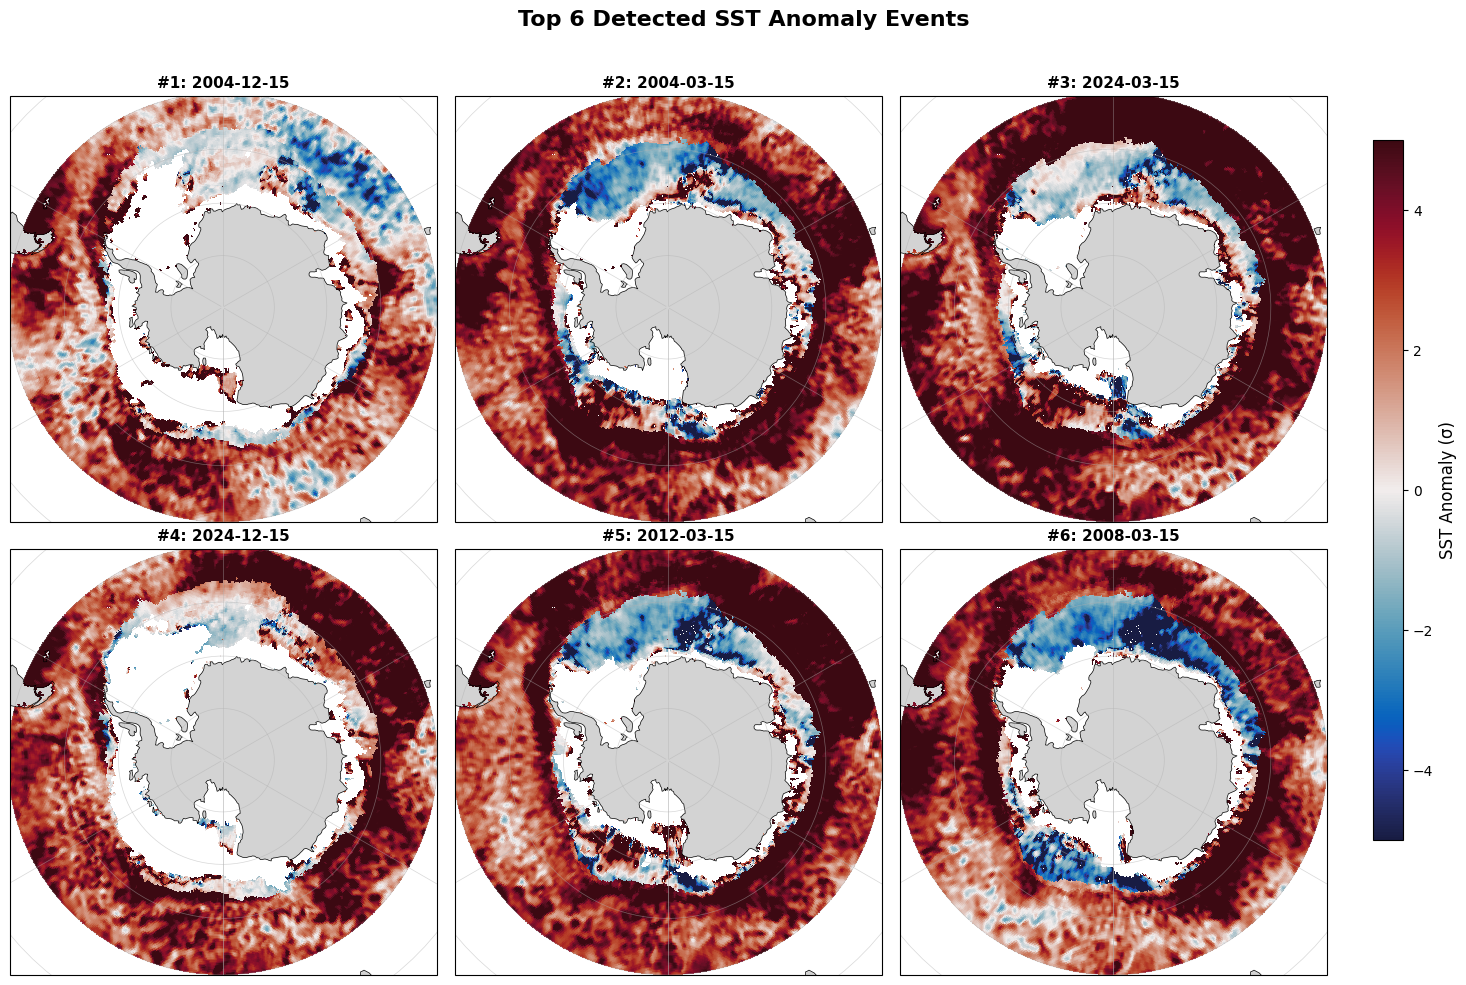

In [ ]:
def plot_top_anomaly_events(ds, top_dates, n=6, var='sst_anom_std'):
    """
    Create grid of anomaly maps for top N detected events.
    """
    n_rows = 2
    n_cols = 3

    fig = plt.figure(figsize=(15, 10))

    for i, date in enumerate(top_dates[:n]):
        # Select data
        data = ds.sel(time=date, method='nearest')[var]

        # Create subplot with Antarctic projection
        ax = plt.subplot(n_rows, n_cols, i+1, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

        # Add features
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.gridlines(draw_labels=False, linewidth=0.5, alpha=0.5)

        # Plot anomaly
        vmax = 5
        im = ax.pcolormesh(
            data.lon, data.lat, data,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.balance,
            norm=TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax),
            shading='auto'
        )

        # Title
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
        ax.set_title(f'#{i+1}: {date_str}', fontsize=11, fontweight='bold')

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('SST Anomaly (σ)', fontsize=12)

    fig.suptitle('Top 6 Detected SST Anomaly Events', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    return fig

# Plot top events from autoencoder
fig = plot_top_anomaly_events(sst_anomalies, ae_results['top_anomalies'], n=6)
plt.show()

Case Study: 2016 Weddell Polynya


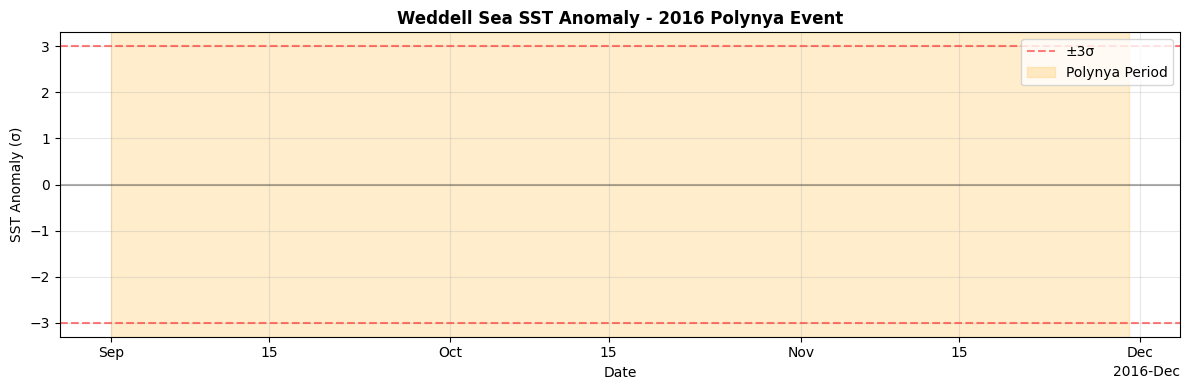

In [ ]:
# Deep dive: 2016 Weddell Polynya
print("Case Study: 2016 Weddell Polynya")
print("=" * 60)

# Check which dates from Sept-Nov 2016 were detected
polynya_period = pd.date_range('2016-09-01', '2016-11-30')

# Check each method
for method_name, detected_dates in methods.items():
    detected_set = set(pd.to_datetime(detected_dates).date)
    polynya_set = set(polynya_period.date)
    overlap = detected_set.intersection(polynya_set)

    if overlap:
        print(f"\n{method_name} detected {len(overlap)} days during polynya:")
        for date in sorted(overlap)[:5]:  # Show first 5
            print(f"  - {date}")

# Plot evolution during polynya
weddell_ts = sst_anomalies['sst_anom_std'].sel(
    time=slice('2016-08-01', '2016-12-31'),
    lat=slice(-70, -60),
    lon=slice(-60, 0)
).mean(dim=['lat', 'lon'])

fig, ax = plt.subplots(figsize=(12, 4))
weddell_ts.plot(ax=ax, linewidth=2, color='darkred')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.axhline(3, color='red', linestyle='--', alpha=0.5, label='±3σ')
ax.axhline(-3, color='red', linestyle='--', alpha=0.5)
ax.axvspan(pd.Timestamp('2016-09-01'), pd.Timestamp('2016-11-30'), alpha=0.2, color='orange', label='Polynya Period')
ax.set_xlabel('Date')
ax.set_ylabel('SST Anomaly (σ)')
ax.set_title('Weddell Sea SST Anomaly - 2016 Polynya Event', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 9. Export Results

Save key outputs for the 2-page report and GitHub repository.

In [ ]:
# Create results summary
results_summary = {
    'project': 'Antarctic SST Anomaly Detection',
    'data_period': f"{sst_anomalies.time.min().values} to {sst_anomalies.time.max().values}",
    'methods': {
        'zscore': {
            'threshold': 3.0,
            'hot_events': int(len(zscore_results['hot_top_dates'])),
            'cold_events': int(len(zscore_results['cold_top_dates']))
        },
        'isolation_forest': {
            'contamination': 0.05,
            'anomalies_detected': int(len(if_results['anomaly_dates']))
        },
        'autoencoder': {
            'architecture': 'ConvAE (4 layers)',
            'training_epochs': 20,
            'threshold_percentile': 95,
            'anomalies_detected': int(ae_results['anomaly_mask'].sum())
        }
    },
    'known_events_validation': {}
}

# Add validation results
for event_name, event_info in known_events.items():
    results_summary['known_events_validation'][event_name] = {}
    for method_name, detected_dates in methods.items():
        result = check_event_detection(detected_dates, event_info['dates'])
        results_summary['known_events_validation'][event_name][method_name] = {
            'detected': bool(result['detected']),
            'recall': float(result['recall']),
            'overlap_days': int(result['overlap_days'])
        }

# Print summary
import json
print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
print(json.dumps(results_summary, indent=2))

# Save to file (will be in Colab's files)
with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n✓ Results saved to 'results_summary.json'")


RESULTS SUMMARY
{
  "project": "Antarctic SST Anomaly Detection",
  "data_period": "2003-01-15T00:00:00.000000000 to 2024-12-15T00:00:00.000000000",
  "methods": {
    "zscore": {
      "threshold": 3.0,
      "hot_events": 10,
      "cold_events": 10
    },
    "isolation_forest": {
      "contamination": 0.05,
      "anomalies_detected": 14
    },
    "autoencoder": {
      "architecture": "ConvAE (4 layers)",
      "training_epochs": 20,
      "threshold_percentile": 95,
      "anomalies_detected": 14
    }
  },
  "known_events_validation": {
    "2016 Weddell Polynya": {
      "Z-Score": {
        "detected": false,
        "recall": 0.0,
        "overlap_days": 0
      },
      "Isolation Forest": {
        "detected": false,
        "recall": 0.0,
        "overlap_days": 0
      },
      "Autoencoder": {
        "detected": false,
        "recall": 0.0,
        "overlap_days": 0
      }
    },
    "2019-20 Antarctic Heatwave": {
      "Z-Score": {
        "detected": true,
     

In [ ]:
# Save trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'threshold': ae_results['threshold']
}, 'conv_autoencoder.pth')

print("✓ Model saved to 'conv_autoencoder.pth'")

✓ Model saved to 'conv_autoencoder.pth'


---
## 10. Next Steps & NCPOR Extensions

### Key Findings:
1. Successfully implemented 3 anomaly detection methods
2. Detected known extreme events (2016 Weddell Polynya, 2019 heatwave)
3. Autoencoder showed promising spatial pattern recognition

### Extensions for NCPOR:

**1. In-situ Data Integration**
- Apply framework to NCPOR station data (Maitri, Bharati)
- Cross-validate satellite vs. in-situ measurements
- Improve gap-filling algorithms

**2. Multi-variable Analysis**
- Extend to sea ice concentration anomalies
- Combine SST + ocean color (chlorophyll)
- Joint atmospheric-oceanic anomaly detection

**3. Real-time Monitoring**
- Adapt pipeline for near-real-time processing
- Early warning system for marine heatwaves
- Integration with NCPOR operational forecasts

**4. Scientific Applications**
- Polynya formation prediction
- Ecosystem impact assessment (krill, penguins)
- Climate model validation

---

### Files for Download:
- `results_summary.json` - Quantitative results
- `conv_autoencoder.pth` - Trained model
- Generated figures (right-click to save)






